In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
import matplotlib.pyplot as plt
import os
import keras
from keras import layers
import tensorflow as tf
import graphviz
import pydot
import sys
import skimage

In [76]:
sys.path.insert(0, '..')
from function import create_new_folder

In [77]:
#generate a dataset
image_path = r'..\images'

In [78]:
#filter any corrupt data
from PIL import Image

num_skipped = 0

for folder_name in os.listdir(image_path):
    folder_path = os.path.join(image_path, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            img = Image.open(fpath) #open and read images in file path
            img.verify() #verify this is an image
        except(IOError, SyntaxError) as e:
            print(f'Bad file: {fname}')
            num_skipped+=1
            # Delete corrupted image
            os.remove(fpath)

print(f'Deleted {num_skipped} images')

Deleted 0 images


In [79]:
img_size = (200, 100) #(height, width)
batch = 32

train_ds = keras.preprocessing.image_dataset_from_directory(
    image_path,
    label_mode='categorical',
    color_mode='grayscale',
    validation_split=0.5,
    subset="training",
    seed=15,
    image_size=img_size,
    batch_size=batch,
    shuffle='False'
)
val_ds = keras.preprocessing.image_dataset_from_directory(
    image_path,
    label_mode='categorical',
    color_mode='grayscale',
    validation_split=0.1,
    subset="validation",
    seed=15,
    image_size=img_size,
    batch_size=batch,
    shuffle='False'
)

Found 1776 files belonging to 31 classes.
Using 888 files for training.
Found 1776 files belonging to 31 classes.
Using 177 files for validation.


In [80]:
def decode_one_hot(batch_of_vectors):
    #Computes indices for the non-zero entries in batched one-hot vectors.
    '''
    Args:
    batch_of_vectors: A Tensor with length-N vectors, having shape [..., N].
    Returns:
    An integer Tensor with shape [...] indicating the index of the non-zero
    value in each vector.
    '''
    nonzero_indices = tf.where(tf.not_equal(batch_of_vectors, tf.zeros_like(batch_of_vectors)))
    reshaped_nonzero_indices = tf.reshape(nonzero_indices[:, -1], tf.shape(batch_of_vectors)[:-1])
    
    return reshaped_nonzero_indices

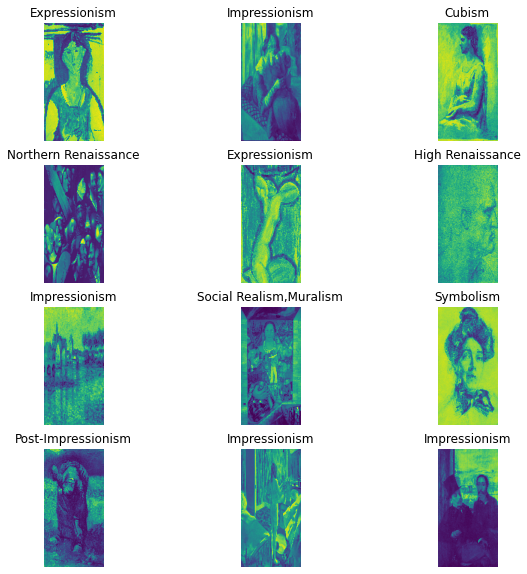

In [81]:
#visualize some of the data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds1.class_names[decode_one_hot(labels[i])])
        plt.axis("off")

In [82]:
#data augmentation using four layers
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.Normalization(axis=-1),
    layers.experimental.preprocessing.RandomContrast(factor=0.3),
    layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2), fill_mode='reflect'),
    layers.experimental.preprocessing.RandomCrop(height=150, width=75),
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomWidth(factor=0.2),
    ])

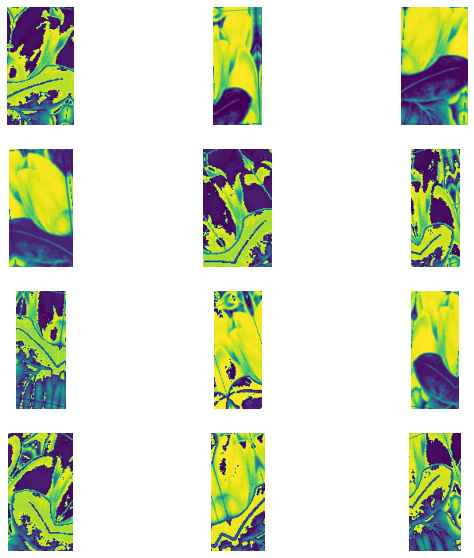

In [83]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(12):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [84]:
#Option 2: apply it to the dataset, so as to obtain a dataset that yields batches of augmented images, like this:

augmented_train_ds = train_ds.map(
lambda x, y: (data_augmentation(x, training=True), y))

#With this option, your data augmentation will happen on CPU, asynchronously, and will be buffered before going into the model.
#If you're training on CPU, this is the better option, since it makes data augmentation asynchronous and non-blocking.
#In our case, we'll go with the first option.